In [1]:
from urllib.request import Request, urlopen
import pandas as pd
import re
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from urllib.parse import unquote
from time import sleep, time

%matplotlib inline

In [2]:
state_acronym_str = """Alabama - AL
Alaska - AK
Arizona - AZ
Arkansas - AR
California - CA
Colorado - CO
Connecticut - CT
Delaware - DE
Florida - FL
Georgia - GA
Hawaii - HI
Idaho - ID
Illinois - IL
Indiana - IN
Iowa - IA
Kansas - KS
Kentucky - KY
Louisiana - LA
Maine - ME
Maryland - MD
Massachusetts - MA
Michigan - MI
Minnesota - MN
Mississippi - MS
Missouri - MO
Montana - MT
Nebraska - NE
Nevada - NV
New Hampshire - NH
New Jersey - NJ
New Mexico - NM
New York - NY
North Carolina - NC
North Dakota - ND
Ohio - OH
Oklahoma - OK
Oregon - OR
Pennsylvania - PA
Rhode Island - RI
South Carolina - SC
South Dakota - SD
Tennessee - TN
Texas - TX
Utah - UT
Vermont - VT
Virginia - VA
Washington - WA
West Virginia - WV
Wisconsin - WI
Wyoming - WY"""
state_acronyms = {
    line.split(' - ')[0]: line.split(' - ')[1]
    for line in state_acronym_str.split('\n')
}

party_acronyms = {
    'Republican': 'R',
    'Democratic': 'D',
    'Independent': 'I',
    'Independent Democrat': 'D', # just Joe Lieberman
}

candidates = [
    'Sen. Sanders, Bernard',
    'Sen. Warren, Elizabeth',
    'Sen. Klobuchar, Amy',
    'Sen. Biden, Joseph R., Jr.',
    'Sen. Bennet, Michael F.',
    'Sen. Booker, Cory A.',
    'Sen. Harris, Kamala D.',
    'Sen. Gillibrand, Kirsten E.',
    'Sen. Gravel, Mike',
    'Sen. Clinton, Hillary Rodham'
]

def choose_party(row):
    name = row.get('Sponsor') or row['Name']
    party_initial = row.get('Party Acronym') or re.search(r'\[(\w{1,2})-\w{2}\]', name).groups(0)[0]
    if party_initial == 'D':
        return 'Democratic'
    elif party_initial == 'ID':
        return 'Democratic'
    elif party_initial == 'R':
        return 'Republican'
    # handle by caucusing https://www.congress.gov/member/harry-byrd/B001209?q={%22search%22:[%22Independent%22]}&s=9&r=7&searchResultViewType=expanded&KWICView=false
    elif 'Sanders' in name or 'King' in name or 'Lieberman' in name or 'Jeffords' in name:
        return 'Democratic'
    elif 'Smith, Bob' in name:
        return 'Republican'
    elif 'Sen. Byrd, Harry F., Jr. [I-VA]' == name:
        return 'Democratic'
    # should only include Dean Barkley
    else:
        return 'Independent'

In [17]:
def load_all_bills():

    bill_files = [
        'senate_bills_law_109_116.csv',
        'senate_bills_law_103_108.csv',
        'senate_bills_law_100_102.csv',
        'senate_bills_law_97_99.csv',
        'senate_bills_law_94_96.csv',
        'senate_bills_law_93.csv',
    ]

    all_bills = pd.concat([pd.read_csv(file, skiprows=3) for file in bill_files]).reset_index()
    all_bills['Congress'] = all_bills['Congress'].map(lambda s: s if s[0] == '1' else ' '+s)
    all_bills['Congress Number'] = all_bills['Congress'].map(lambda s: int(re.sub(r'[a-z]', '', s.split()[0])))
    all_bills['Name Bill'] = all_bills['Title'].map(lambda t: 'designate' in t.lower().split())
    all_bills['Type'] = all_bills['Legislation Number'].map(lambda n: n.split()[0])
    all_bills['Number'] = all_bills['Legislation Number'].map(lambda n: int(n.split()[1]))
    all_bills['Sponsor Name'] = all_bills['Sponsor'].map(lambda s: re.sub(' \[[\w\-]+\]', '', s))
    all_bills['Party'] = all_bills.apply(choose_party, axis=1)
    all_bills['Congress'] = all_bills['Congress'].map(lambda s: s.replace(' Congress', ''))
    all_bills = all_bills[['Congress', 'Congress Number', 'Legislation Number', 'Type', 'Number', 'Title', 'Sponsor Name', 'Party', 'Number of Cosponsors', 'Name Bill', 'Latest Action Date', 'URL']]
    return all_bills


all_bills = load_all_bills()

In [19]:
congress_map = all_bills[['Congress', 'Congress Number']].drop_duplicates()

In [20]:
len(all_bills)

4321

In [21]:
len(all_bills.loc[~all_bills['Name Bill']])

3722

In [22]:
def sponsor_score(row):
    if not row['Cosponsor']:
        return 1.0 if row['Number of Cosponsors'] == 0 else 0.5
    else:
        return 0.5 / row['Number of Cosponsors']

def load_sponsors():
    sponsors = pd.read_csv('cosponsors_fixed.csv', index_col=False)
    sponsors['Sponsor Name'] = sponsors['Sponsor'].map(lambda s: re.sub(' \[[\w\-]+\]', '', s))
    sponsors['Party'] = sponsors.apply(choose_party, axis=1)
    sponsors = sponsors.drop('Sponsor', axis=1)
    sponsors['Weighted Score'] = sponsors.apply(sponsor_score, axis=1)
    sponsors['Sponsored Count'] = sponsors['Cosponsor'].apply(lambda s: 0 if s else 1)
    sponsors['Cosponsored Count'] = sponsors['Cosponsor'].apply(lambda s: 1 if s else 0)
    
    return sponsors

sponsors = load_sponsors()

In [23]:
candidates_raw = sponsors.loc[~sponsors['Name Bill']]\
    .groupby('Sponsor Name')[['Sponsored Count', 'Cosponsored Count']]\
    .sum()\
    .loc[candidates].sort_values(['Sponsored Count', 'Cosponsored Count'], ascending=False)

candidates_raw.to_csv('candidate_sponsors.csv')

In [24]:
bills_parties = sponsors[['Congress Number', 'Legislation Number', 'Party']].copy()
bills_parties['Party Count'] = sponsors['Party']
bills_parties = bills_parties\
    .groupby(['Congress Number', 'Legislation Number'])\
    .agg({'Party': 'max', 'Party Count': 'nunique'})
    #.reset_index()
def choose_bipartisan(row):
    if row['Party Count'] > 1:
        return 'Bipartisan'
    else:
        return row['Party']

all_bills = all_bills.drop(['Party'], axis=1).join(bills_parties, on=['Congress Number', 'Legislation Number'], how='left')
all_bills['Party'] = all_bills.apply(choose_bipartisan, axis=1)

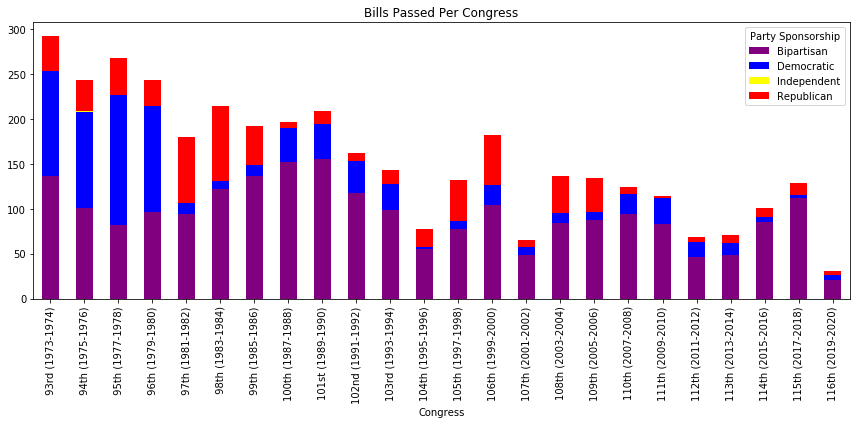

In [33]:
all_bills.loc[~all_bills['Name Bill']]\
    .rename(columns={'Party': 'Party Sponsorship'})\
    .pivot_table(values='Number', index='Congress', columns='Party Sponsorship', aggfunc=pd.Series.nunique)\
    .plot.bar(stacked=True, color=['purple', 'blue', 'yellow', 'red'], title='Bills Passed Per Congress', figsize=(12,6))
plt.tight_layout()
plt.savefig("bills_per_congress.png")

In [27]:
def whole_name_func(row):
    return row['Name'].replace('Senator', 'Sen.')

def to_congress(year):
    if year == 'Present':
        year = 2020
    return (int(year) - 1788) // 2

def get_congresses(terms):
    senate_terms = terms.split(' | ')[0]
    matches = [
        c
        for match in re.findall(r'\d{4}-(?:\d{4}|Present)', senate_terms)
        for c in range(to_congress(match.split('-')[0])+1, to_congress(match.split('-')[1]) + 1)
    ]
    return matches

def load_senators():
    senators = pd.read_csv('senators.csv', skiprows=3)
    senators['Name'] = senators.apply(whole_name_func, axis=1)
    senators['Congresses']  = senators['Terms'].map(get_congresses)
    senators = senators.drop('District', axis=1)
    senators['Current'] = senators['Congresses'].map(lambda cs: 116 in cs)
    senators['Party Acronym'] = senators['Party'].map(party_acronyms)
    senators['Party'] = senators.apply(choose_party, axis = 1)
    senators = senators.drop('Party Acronym', axis=1)
    return senators

senators = load_senators()

In [28]:
def calculate_senator_scores(senators, sponsors):
    rows = []
    for (i, row) in senators[['Name', 'Congresses', 'Party']].iterrows():
        for congress in row['Congresses']:
            rows.append((row['Name'], row['Party'], congress))
    senators_by_congress = pd.DataFrame(rows, columns=['Sponsor Name', 'Party', 'Congress Number'])
    senator_score_by_congress = sponsors.loc[~sponsors['Name Bill']]\
        .groupby(['Sponsor Name', 'Congress Number'])[['Sponsored Count', 'Cosponsored Count', 'Weighted Score']].sum()

    senator_score_by_congress = senators_by_congress\
        .loc[senators_by_congress['Congress Number'] >= 93]\
        .join(senator_score_by_congress, on=['Sponsor Name', 'Congress Number'], how='left')\
        .fillna(0.0)\

    score_by_congress = senator_score_by_congress\
        .groupby(['Party', 'Congress Number'])[['Weighted Score']]\
        .mean()

    senators_scores = senator_score_by_congress\
        .join(
            score_by_congress.rename(columns={'Weighted Score': 'Typical Weighted Score'}),
            on=['Party', 'Congress Number'],
            how='left',
        )\
        .groupby('Sponsor Name')[['Sponsored Count', 'Cosponsored Count', 'Weighted Score', 'Typical Weighted Score']].sum()
    senators_scores['Score Relative to Expectation'] = senators_scores['Weighted Score'] / senators_scores['Typical Weighted Score']
    senators_scores = senators_scores.sort_values(['Score Relative to Expectation'], ascending=False)
    senators_scores['Rank'] = pd.RangeIndex(0, len(senators_scores)) + 1
    senators_scores = senators_scores.join(
        senators[['Name', 'Party', 'Current']].rename({'Name': 'Sponsor Name'}, axis=1).set_index('Sponsor Name'),
        on=['Sponsor Name'],
        how='left',
    )
    senators_scores = senators_scores[['Party', 'Current', 'Sponsored Count', 'Cosponsored Count', 'Weighted Score', 'Score Relative to Expectation', 'Rank']]
    return (score_by_congress, senators_scores)

score_by_congress, senators_scores = calculate_senator_scores(senators, sponsors)    

In [29]:
senators_scores\
    .loc[candidates].drop(['Current', 'Party'], axis=1)\
    .sort_values(['Score Relative to Expectation'], ascending=False)\
    .to_csv('candidate_scores.csv')

In [30]:
senators_scores.loc[senators_scores['Current']].to_csv('all_senator_scores.csv')

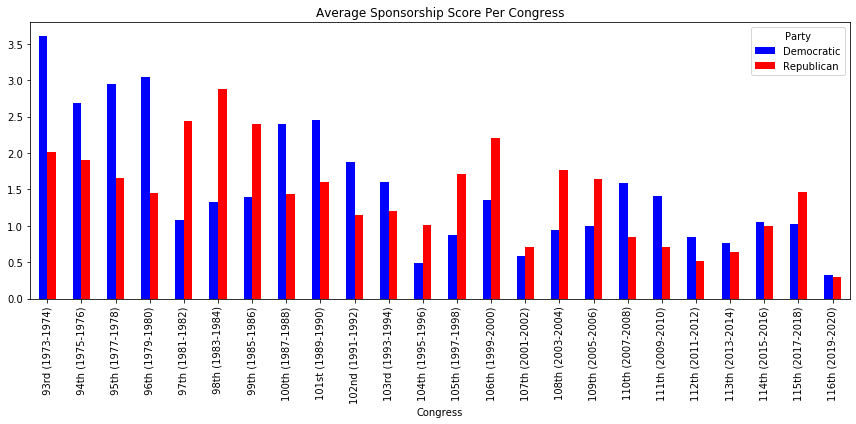

In [32]:
score_by_congress\
    .loc[['Republican', 'Democratic']]\
    .join(congress_map.set_index('Congress Number'), on=['Congress Number'], how='left')\
    .pivot_table(
        index='Congress',
        columns='Party',
        values='Weighted Score'
    ).plot\
    .bar(color=['blue', 'red'], title='Average Sponsorship Score Per Congress', figsize=(12,6))
plt.tight_layout()
plt.savefig("sponsorship_per_congress.png")

In [ ]:
# code to scrape sponsors, currently broken

def get_cosponsors(url):
    request = Request(url + '/cosponsors', headers={'User-Agent': 'Mozilla/5.0'})
    try:
        with urlopen(request) as response:
            html = response.read()
    except:
        sleep(3)
        print("Got error, sleeping for 3 seconds")
        with urlopen(request) as response:
            html = response.read()
    soup = BeautifulSoup(html, 'html.parser')
    return [
        sen.get_text().strip('*')
        for table in soup.find_all(attrs={"class": "item_table"})
        for sen in table.find_all('a')
    ]    

def generate_sponsors(df, sleep_secs = 0, limit=10000, notify_every=100, file_name='cosponsors.csv'):
    sponsors = df\
        .iloc[0:limit][['URL', 'Congress Number', 'Legislation Number', 'Name Bill', 'Number of Cosponsors', 'Sponsor']]\
        .copy()\
        .reset_index()
    sponsors['Cosponsor'] = False
    new_rows = []
    start_time = time()
    sponsors.drop('URL', axis=1)\
        .sort_values(['Congress Number', 'Legislation Number', 'Cosponsor', 'Sponsor'], ascending=False)\
        .to_csv(file_name, index=False)
    for (i, row) in sponsors.iterrows():
        cosponsors = get_cosponsors(row['URL'])
        for cosponsor in cosponsors:
            new_rows.append((
                row['Congress Number'],
                row['Legislation Number'],
                row['Name Bill'],
                row['Number of Cosponsors'],
                cosponsor,
                True
            ))
        sleep(sleep_secs)
        if (i % notify_every == 0 and i > 0) or (i == len(sponsors) -1):
            print('Processed {0} bills in {1} seconds'.format(i, time() - start_time))
            new_sponsors =  pd.DataFrame(new_rows, columns=['Congress Number', 'Legislation Number', 'Name Bill', 'Number of Cosponsors', 'Sponsor', 'Cosponsor'])
            new_rows=[]
            with open(file_name, 'a') as file:
                new_sponsors.to_csv(file, header=False, index=False)
    sponsors = pd.read_csv(file_name)\
        .sort_values(['Congress Number', 'Legislation Number', 'Cosponsor', 'Sponsor'], ascending=False)
    sponsors.to_csv(file_name)
    return sponsors
sponsors = generate_sponsors(all_bills)